## Define Custom ResNet Model: V1

In [ ]:
!pip install -U torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNetCustom():
    return ResNet(BasicBlock, [3, 3, 2, 2])


## Define Custom ResNet Model: V2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, initial_channels=64, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = initial_channels

        self.conv1 = nn.Conv2d(3, initial_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(initial_channels)
        self.layer1 = self._make_layer(block, initial_channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, initial_channels * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, initial_channels * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, initial_channels * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(initial_channels * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# def ResNetCustom():
#     return ResNet(BasicBlock, [2, 1, 1, 1])


def ResNetCustom():
    return ResNet(BasicBlock, [2, 2, 2, 1], initial_channels=56)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlockCIFAR(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetCIFAR, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)

        # For "ResNet-20", num_blocks = [3, 3, 3]
        self.layer1 = self._make_layer(block, 16,  num_blocks[0], stride=1)  # 3 blocks
        self.layer2 = self._make_layer(block, 32,  num_blocks[1], stride=2)  # 3 blocks
        self.layer3 = self._make_layer(block, 64,  num_blocks[2], stride=2)  # 3 blocks

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size(3))  # Global average pool
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNetCIFAR(BasicBlockCIFAR, [3, 3, 3])


In [ ]:
# last try



## Get Num of Params

In [ ]:
def get_num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(get_num_params(ResNetCustom()))

4942402


## Train and Test

In [ ]:
def validate(net, dataloader, device):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    net.train()
    return 100. * correct / total


scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 for matmul
torch.backends.cudnn.allow_tf32 = True



def train(num_epochs=250):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetCustom().to(device)
    torch.backends.cudnn.conv_bias_channels_last = True
    net = net.to(memory_format=torch.channels_last)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.1,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
   

    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])


    cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_size = int(0.9 * len(cifar_trainset))  # 90% for training, 10% for validation
    val_size = len(cifar_trainset) - train_size
    trainset, valset = torch.utils.data.random_split(cifar_trainset, [train_size, val_size])
    trainloader = DataLoader(trainset, batch_size=512, shuffle=True)
    valloader = DataLoader(valset, batch_size=512, shuffle=False)

    net.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100. * correct / total
        val_acc = validate(net, valloader, device) 
        print(f"Epoch {epoch+1}: Loss = {running_loss/len(trainloader):.4f}, Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")
        scheduler.step()
    torch.save(net.state_dict(), 'resnet_cifar10.pth')
    return net

def test(net):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    net.eval()
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=512, shuffle=False)
    correct = 0
    total = 0
    with torch.inference_mode():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')
    torch.save(net.state_dict(), 'resnet_cifar10.pth')

print(torch.cuda.is_available())
net = train()
test(net)


<ipython-input-15-c1a4144b68a7>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Accuracy: 94.31%


## Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


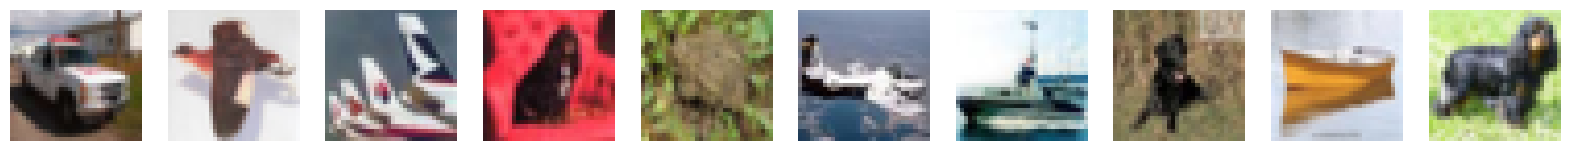

In [ ]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import random as rand
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import pickle

classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def unpickle(file):
    """ read pickle file """
    with open(file, 'rb') as fo:
        datadict = pickle.load(fo, encoding='bytes')
    return datadict

def load_eval(filename):
    """ load eval batch """
    datadict = unpickle(filename)
    ids = datadict[b'ids']
    imgs = datadict[b'data']
    imgs = imgs.astype("uint8")
    return ids, imgs

# Create a custom dataset class
class EvalDataset(Dataset):
    def __init__(self, ids, images, transform=None):
        self.ids = ids
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        id = self.ids[idx]
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return id, img

ids, imgs = load_eval('drive/MyDrive/cifar_test_nolabel.pkl')

# Visualize a few images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    idx = rand.randint(0, len(imgs))
    axes[i].imshow(imgs[idx])
    axes[i].axis("off")
plt.show()

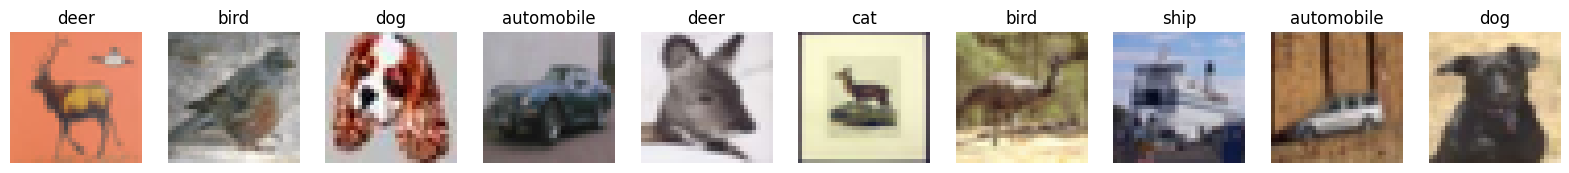

In [ ]:
def evaluate(dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNetCustom().to(device)
    # Load the trained model
    net.load_state_dict(torch.load('drive/MyDrive/resnet_cifar10_v2.pth'))
    net.eval()
    with torch.no_grad():
        for ids, inputs in dataloader:
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred = predicted.data.cpu().numpy()
            df = pd.DataFrame({'ID': ids.numpy(), 'Labels': y_pred})
            df.to_csv('submission.csv', index=False)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
eval_dataset = EvalDataset(ids, imgs, transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=10000, shuffle=False)
evaluate(eval_dataloader)

# Visualize a few labeled images
df = pd.read_csv('submission.csv')
df_elements = df.sample(n=10)
df_elements['Labels'] = df_elements['Labels'].map(lambda x: classes[x])
df_elements = df_elements.to_numpy()

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(imgs[df_elements[i][0]])
    axes[i].set_title(df_elements[i][1])
    axes[i].axis("off")